In [ ]:
# default_exp core

# inpaint_melanoma

> Inpaint a skin lesion

In [ ]:
#export
import argparse
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.optim
from copy import copy, deepcopy
import time
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
from skimage import measure, morphology
from itertools import groupby, count
import matplotlib.patches as patches
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from torch.autograd import Variable
from scipy.spatial import distance
import sys
from PIL import Image
from matplotlib.gridspec import GridSpec

In [ ]:
#export
sys.path.append('../models')

In [ ]:
#export
from models.skip import skip
from utils.inpainting_utils import *

In [ ]:
#export
from inpainting_nodules_functions import *
import warnings
from torch.autograd import Variable
# from google.colab import drive
from scipy import ndimage
from skimage import filters

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#export
def rgb2gray(rgb):
    '''https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python'''
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def otsu_thresh_4largest_component(img2):
    val = filters.threshold_otsu(img2)
    mask_otsu_orig = img2<val
    mask_otsu = ndimage.morphology.binary_erosion(mask_otsu_orig, iterations=20)
    mask_otsu = ndimage.morphology.binary_dilation(mask_otsu, iterations=80)
    mask_otsu = ndimage.morphology.binary_fill_holes(mask_otsu)
    labeled_mask, cc_num = ndimage.label(mask_otsu)
    sorted_comp = np.bincount(labeled_mask.flat)
    sorted_comp = np.sort(sorted_comp)[::-1]
    mask_lesions = []
    for i in np.arange(1, np.min([len(sorted_comp), 4])):
        mask_lesions.append((labeled_mask == np.where(np.bincount(labeled_mask.flat) == sorted_comp[i])[0][0]))         
    return mask_lesions

def component_closest_center(img2, masks_lesions):
    y_half, x_half = [i//2 for i in np.shape(img2)]
    y_half_x_half = np.asarray([y_half, x_half])
    ml_closest = masks_lesions[0] # default
    dist_min = 10000
    for i in masks_lesions:
        yy,xx = np.where(i==1) 
        ymed_xmed = np.asarray([np.median(yy), np.median(xx)])
        dist_new = distance.cdist(np.expand_dims(y_half_x_half,0), np.expand_dims(ymed_xmed,0))
        if dist_new < dist_min:
            dist_min = dist_new
            ml_closest = i
    return ml_closest

def get_center(img, part=.25):
    factor = 32
    y_half, x_half, _ = [i//2 for i in np.shape(img)]
    y_include, x_include = np.asarray([y_half, x_half])* part
    y_include = y_include + (factor - y_include % factor)
    x_include = x_include + (factor - x_include % factor)
    y_part1, x_part1 = int(y_half - y_include), int(x_half - x_include)
    y_part2, x_part2 = int(y_half + y_include), int(x_half + x_include)
    y_part1, y_part2, x_part1, x_part2
    return img[y_part1: y_part2, x_part1: x_part2,:], y_part1, x_part1

def denormalizePatches(img):
    img_min = np.min(img)
    img_max = np.max(img)
    img = img * img_max + img_min
    img = img.astype('int16')
    return img

In [ ]:
#export
def figs_horizontal2(ff, names_selected, suffix_available, path_source):
    f1 = [names_selected+j for j in suffix_available if names_selected+j in ff]
    f1 = np.unique(f1)
    f1 = np.sort(f1)
    n_img = len(f1)
    fig, ax = plt.subplots(1,n_img,figsize=(24,5))
    for idx,i in enumerate(f1):
        # name_display = '_'.join(names_selected.split('_')[1:])
        name_display = i.split('_ISIC')[0].split('_')[-1]
        a = np.fromfile(f'{path_source}{i}',dtype='int16')
        a = a/255
        a = np.clip(a,0,1)
        a = np.reshape(a, (3,512,512))
        a = np.swapaxes(a,0,1)
        a = np.swapaxes(a,1,2)
        ax[idx].imshow(a)
        ax[idx].text(10,50,name_display)
    for axx in ax.ravel(): axx.axis('off')
    plt.tight_layout()
    print(names_selected)
    return f1

In [ ]:
#export
def figs_comparison(ff, names_selected, suffix_available, gen_idx, folder='/mnt/90cf2a10-3cf8-48a6-9234-9973231cadc6/Kaggle/melanoma/datasets_preprocessed/size_512/'):
    f1 = [names_selected+j for j in suffix_available if names_selected+j in ff]
    f1 = np.unique(f1)
    f1 = np.sort(f1)
    n_img = len(f1)
    i = f1[gen_idx]
    
    key = 'ISIC'+suffix_available[0].split('.raw')[0].split('ISIC')[-1]
    orig = plt.imread(f'{folder}{key}.jpg')
    mask = np.load(f'{folder}mask_{key}.npz')
    mask = mask.f.arr_0
    
    fig, ax = plt.subplots(1,4,figsize=(12,5))
    name_display = i.split('_ISIC')[0].split('_')[-1]
    inpain = np.fromfile(f'{path_source}{i}',dtype='int16')
    inpain = inpain/255
    inpain = np.clip(inpain,0,1)
    inpain = np.reshape(inpain, (3,512,512))
    inpain = np.swapaxes(inpain,0,1)
    inpain = np.swapaxes(inpain,1,2)
    ax[1].imshow(orig)
    ax[0].imshow(orig)
    ax[0].imshow(mask, alpha=.3)
    ax[2].imshow(inpain)
    ax[3].imshow(inpain)
    ax[3].imshow(mask, alpha=.3)
    for axx in ax.ravel(): axx.axis('off')
    plt.tight_layout()
    return key, inpain

In [ ]:
#export
def figs_horizontal3(ff, names_selected, suffix_available, path_results):
    f1 = [names_selected+j for j in suffix_available if names_selected+j in ff]
    f1 = np.unique(f1)
    f1 = np.sort(f1)
    n_img = len(f1)
    fig, ax = plt.subplots(1,n_img,figsize=(24,5))
    for idx,i in enumerate(f1):
      name_display = i.split('_ISIC')[0].split('_')[-1]
      a = Image.open(f'{path_results}{i}')
      ax[idx].imshow(a)
      ax[idx].text(10,50,name_display)
    for axx in ax.ravel(): axx.axis('off')
    plt.tight_layout()
    print(names_selected)
    return f1

In [ ]:
#export
def plot_inpaints_pairs(mse_error, images_raw, images_combined, epochs_saved, filename, archi, params, path_save=''):
    fontsize = 20
    color1 = "#3F5D7D"
    color2 = "#990F02"
    color3 = "#ffe84f"
    widths = [1,2,2,2,2]
    fig=plt.figure(figsize=(18,8));
    gs=GridSpec(2,5, width_ratios=widths)
    ax1=fig.add_subplot(gs[:,0]) # First row, first column
    ax2=fig.add_subplot(gs[0,1]) # First row, second column
    ax3=fig.add_subplot(gs[0,2]) # First row, third column
    ax4=fig.add_subplot(gs[0,3])
    ax5=fig.add_subplot(gs[0,4])
    ax6=fig.add_subplot(gs[1,1])
    ax7=fig.add_subplot(gs[1,2])
    ax8=fig.add_subplot(gs[1,3])
    ax9=fig.add_subplot(gs[1,4])
    
    count=0
    for i, ax_ in zip(images_raw,      [ax2, ax4, ax6, ax8]): 
        ax_.imshow(i)
        ax_.text(10, 50, str(epochs_saved[-4+count]*10), fontsize=fontsize)
        count+=1
    for i, ax_ in zip(images_combined, [ax3, ax5, ax7, ax9]): ax_.imshow(i)
    for i in [ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]: i.axis('off')
        
    name = f'{archi}\n{params}'
    name = name.replace('_LR','\nLR')
    ax9.text(10,140,name, fontsize=fontsize)
    ax1.semilogy(mse_error, color=color1)
    epochs_saved = np.asarray(epochs_saved)*10
    ax1.semilogy(np.asarray(epochs_saved)[-4:],np.asarray(mse_error)[np.asarray(epochs_saved)][-4:], marker='.', linestyle='None', markersize=20, color=color1)
    fig.tight_layout()
    
    if len(path_save)>0:
        fig.savefig(f'{path_save}ov_{filename}_{name}.png' )
        plt.close()

In [ ]:
#hide
filename = 'ISIC_0076742'
# if cloud
# drive.mount('/content/gdrive/')
# path_source = '/content/gdrive/My Drive/KCL/melanoma/size_512/'
# path_img_dest = '/content/gdrive/My Drive/KCL/melanoma/results_512/'
# if local
path_source = '/mnt/c/Users/octav/Documents/Datasets/melanoma/size_512/'
path_img_dest = '/mnt/c/Users/octav/Documents/Datasets/melanoma/results_size_512/'
img = plt.imread(f'{path_source}{filename}.jpg')
mask_lesion = np.load(f'{path_source}mask_{filename}.npz')
mask_lesion = mask_lesion.f.arr_0
mask_inpain = ~mask_lesion

In [ ]:
#hide
# parameters
run_epochs = 51 # 1001
channels_input = 32
channels_layers = [32, 64]
channels_skip = [0]*len(channels_layers)
channels_layers_str = [str(i) for i in channels_layers]
layers_str ='_'.join(channels_layers_str)
name = f'{run_epochs}_{channels_input}_{layers_str}'
name_for_fig = f'{channels_input}_{layers_str}'

In [ ]:
#hide
# reshape and normalize
img = np.swapaxes(img,1,2)
img = np.swapaxes(img,0,1)
mask_inpain = mask_inpain.astype('int')
# normalize
img_min = np.min(img)
img_max = np.max(img)
img = (img - img_min) / (img_max - img_min)
print(f'img: {np.shape(img), np.shape(mask_inpain)}')

img: ((3, 512, 512), (512, 512))


In [ ]:
#hide
def closure():
    global i
    images_all = []
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
    out = net(net_input)
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %.12f' % (i, total_loss.item()), '\r', end='')
    
    if  PLOT:
        out_np = torch_to_np(out)
        image_to_save = out_np
        images_all.append(image_to_save)
        
    i += 1    

    return total_loss, images_all

In [ ]:
#hide
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
PLOT = True
imsize = -1
dim_div_by = 64
torch.cuda.empty_cache()

In [ ]:
#hide
pad = 'zero' 
OPT_OVER = 'net'
OPTIMIZER = 'adam'
INPUT = 'noise'
input_depth = channels_input 
num_iter = run_epochs 
param_noise = True
show_every = 500
reg_noise_std = 0.1
LR = 0.01
restart_i = 0
restart = True
params = f'skip={channels_skip}_LR={LR}_noise={reg_noise_std}'

In [ ]:
#hide
mse_error_all = []
img_np = img
img_mask_np = mask_inpain

In [ ]:
#hide
while restart == True:
    start = time.time()
    print(f'training initialization {restart_i} with LR = {LR:.12f}')
    restart_i += 1
    # Loss
    mse = torch.nn.MSELoss().type(dtype)
    img_var = np_to_torch(img_np).type(dtype)
    mask_var = np_to_torch(img_mask_np).type(dtype)

    net = skip(input_depth, img_np.shape[0], 
            num_channels_down = channels_layers, 
            num_channels_up   = channels_layers[::-1], 
            num_channels_skip = channels_skip, 
            upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3, 
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    net = net.type(dtype)        
    net_input = get_noise2(input_depth, INPUT, img_np.shape[1:], noise_type='n').type(dtype)

    i = 0
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    print(f'noise: {type(noise.detach().cpu().numpy())}, {np.shape(noise.detach().cpu().numpy())}, {np.min(noise.detach().cpu().numpy()), np.mean(noise.detach().cpu().numpy()), np.max(noise.detach().cpu().numpy())}')

    p = get_params(OPT_OVER, net, net_input)
    mse_error, images_generated_all, best_iter, restart = optimize_melanoma_v1(OPTIMIZER, p, closure, LR, num_iter, show_every, path_img_dest, restart, annealing=True, lr_finder_flag=False)
    
    mse_error = [i.detach().cpu().numpy() for i in mse_error]

    if restart_i % 10 == 0: # reduce lr if the network is not learning with the initializations
        LR /= 1.2
    if restart_i == 30: # if the network cannot be trained continue (might not act on for loop!!)
        continue

training initialization 0 with LR = 0.010000000000
using get_noise2
noise: <class 'numpy.ndarray'>, (1, 32, 512, 512), (-0.5037879, -2.7219452e-05, 0.5289863)


In [ ]:
#hide
save_epochs = [1,2,3,4,5] #[10,20,40,80,100]
images=[]
images_raw=[]
for i in save_epochs:
    img_tmp = images_generated_all[i] * mask_lesion + img *  mask_inpain
    img_tmp = np.swapaxes(img_tmp[0], 0,1); img_tmp = np.swapaxes(img_tmp, 1,2)
    images.append(img_tmp)
    raw_tmp = images_generated_all[i]
    raw_tmp = np.swapaxes(raw_tmp[0], 0,1); raw_tmp = np.swapaxes(raw_tmp, 1,2)
    images_raw.append(raw_tmp)

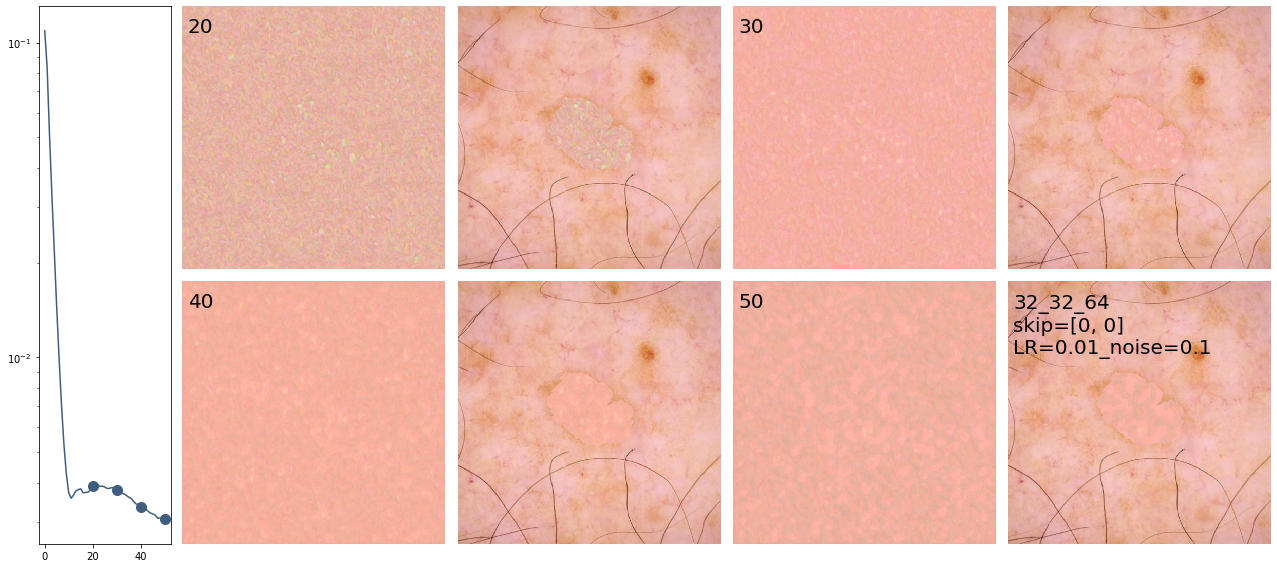

In [ ]:
#hide
plot_inpaints_pairs(mse_error, images_raw, images, save_epochs, filename, name_for_fig, params)

In [ ]:
#hide
# save individual images
image_denorm = [denormalizePatches(i) for i in images]
for (img_to_save, epoch_to_save) in zip(image_denorm, save_epochs):
    im2save = Image.fromarray(img_to_save.astype(np.uint8))
    im2save.save(f'{path_img_dest}{filename}_{name}_{epoch_to_save:04d}.png')